In [3]:
#notebook heavily stolen from https://github.com/mirandabryson/WH-All-Hadronic-Coffea-Tools/blob/master/cutflownotebook.ipynb
#and https://github.com/mirandabryson/WH-All-Hadronic-Coffea-Tools/blob/master/Jackson's%20Notebook.ipynb 
import os
import time
import glob
import re
from functools import reduce

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import pandas as pd
import uproot_methods
import awkward


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.cutflow import Cutflow

In [4]:
def addRowToCutFlow(output, df, name, selection):
    '''
    add one row with name and selection for each process to the cutflow accumulator
    '''

    if selection is not None:
        output['cutflow'][name] += (sum(df['weight'][selection].flatten())*60)
    else:
        output['cutflow'][name] += (sum(df['weight'].flatten())*60)
            
def getCutFlowTable(output, outputname, lines = ['all']):
    '''
    Takes a cache and returns a formated cut-flow table of processes.
    Lines and processes have to follow the naming of the coffea processor output.
    '''
    res = pd.DataFrame([])
    for line in lines:
        res = res.append(pd.DataFrame({outputname : output['cutflow'][line]}, index=[line]))
    return res

In [17]:
class WHhadProcessor(processor.ProcessorABC):
    """Processor used to find the pt rations"""
    def __init__(self):

         # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset", "Primary dataset")
        pt_axis             = hist.Bin("pt", r"$p_{T}$ (GeV)", 50, 200, 1000)
        mass_axis           = hist.Bin("mass", r" mass (GeV)", 50, 0, 250)
        eta_axis            = hist.Bin("eta", r"$\eta$", 60, -5.5, 5.5)
        multiplicity_axis   = hist.Bin("multiplicity", r"N", 20, 0, 20)
        r_axis               = hist.Bin("r", r"$\Delta R$", 80, 0, 4)

        self._accumulator = processor.dict_accumulator({
            'number j':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number b':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number h':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number w':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number fj':            hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'met':                  hist.Hist("Counts", dataset_axis, pt_axis),
            'h mass':               hist.Hist("Counts", dataset_axis, mass_axis),
            'min_dphi':             hist.Hist("Counts", dataset_axis, eta_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        
        #Jagged Arrays
        #MET
        metphi = df["MET_phi"]
        metpt = df["MET_pt"]
        
        #leptons
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content,
            cutbased = df['Electron_cutBased'].content,
        )
        
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content, 
            eta=df['Muon_eta'].content, 
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            pdgid=df['Muon_pdgId'].content,
            mini_iso=df['Muon_miniPFRelIso_all'].content, 
            looseid =df['Muon_looseId'].content
        )
        
        taus = JaggedCandidateArray.candidatesfromcounts(
            df['nTau'],
            pt=df['Tau_pt'].content, 
            eta=df['Tau_eta'].content, 
            phi=df['Tau_phi'].content,
            mass=df['Tau_mass'].content,
            decaymode=df['Tau_idDecayMode'].content,
            newid=df['Tau_idMVAnewDM2017v2'].content,
        )
        
        isotracks = awkward.JaggedArray.zip(
            pt=df['IsoTrack_pt'], 
            eta=df['IsoTrack_eta'], 
            phi=df['IsoTrack_phi'], 
            rel_iso=df['IsoTrack_pfRelIso03_all'], 
        )
        
        #jets
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content, 
            eta=df['Jet_eta'].content, 
            phi=df['Jet_phi'].content,
            btag=df['Jet_btagDeepB'].content, 
            jetid=df['Jet_jetId'].content, 
            mass=df['Jet_mass'].content,
        )
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'].content, 
            eta=df['FatJet_eta'].content, 
            phi=df['FatJet_phi'].content, 
            mass=df['FatJet_mass'].content, 
            softdrop=df["FatJet_msoftdrop"].content,  
            fromH = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            fromW_MD = df['FatJet_deepTagMD_WvsQCD'].content, 
            fromW_MC = df['FatJet_deepTag_WvsQCD'].content
            
        )
        
        
        #leptons
        
        e_cut = (electrons.pt > 10) & (abs(electrons.eta) < 2.4) & (electrons.mini_iso < 0.1) & (electrons.cutbased >= 1)
        electrons = electrons[e_cut]
        
        m_cut = (muons.pt > 10) & (abs(muons.eta) < 2.4) & (muons.looseid) & (muons.mini_iso < 0.2)
        muons = muons[m_cut]
    
        t_cut = (taus.pt > 10) & (abs(taus.eta) < 2.4) & (taus.decaymode) & (taus.newid >= 8)
        taus = taus[t_cut]
        
        it_cut = (isotracks.pt > 10) & (abs(isotracks.eta) < 2.4) & ((isotracks.rel_iso < (0.1*isotracks.pt)) | (isotracks.rel_iso < 6))
        isotracks = isotracks[it_cut]

        
        #ak4's
        goodjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>1))
        goodjets = jets[goodjcut]
        goodjets       = goodjets[~goodjets.match(muons, deltaRCut=0.4)] # remove jets that overlap with muons
        goodjets       = goodjets[~goodjets.match(electrons, deltaRCut=0.4)] # remove jets that overlap with electrons
        njets = goodjets.counts
        jetpt_sorted = goodjets.pt.argsort(ascending=False)
        leadjet = goodjets[jetpt_sorted==0]
        subleadjet = goodjets[jetpt_sorted==1]
        leadjets = goodjets[jetpt_sorted <= 1]
        
        
        leadingJets = goodjets[:,:2]
        dijets = leadingJets.choose(2)
        dphiDiJet = np.arccos(np.cos(dijets.i0.phi-dijets.i1.phi))
        
        min_dphiJetMet4 = np.arccos(np.cos(goodjets[:,:4].phi-metphi)).min()
        
        bjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>1) & (jets.btag>0.4184))
        bjets = jets[bjcut]
        numbjets = bjets.counts
        bjetpt = bjets.pt
        bjetpt_sorted = bjetpt.argsort(ascending=False)
        leadbjet = bjets[bjetpt_sorted==0]
        subleadbjet = bjets[bjetpt_sorted==1]
        leadbjets = bjets[bjetpt_sorted <= 1]
            
        nonbjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>1) & (jets.btag<0.4184))
        nbjets = jets[nonbjcut]
        nbjetpt_sorted = nbjets.pt.argsort(ascending=False)
        leadnbjet = nbjets[nbjetpt_sorted==0]
        subleadnbjet = nbjets[nbjetpt_sorted==1]
        leadnbjets = nbjets[nbjetpt_sorted <= 1]

        
        #ak8's
        goodfjcut = (fatjets.pt > 200)
        goodfatjets = fatjets[goodfjcut]
        
        goodfatjets = goodfatjets.pt.argsort(ascending=False)
        leadfatjets = goodfatjets[goodfatjets <= 1]
        
       
        
        leadingFatJets = goodfatjets[:,:2]
        difatjets = leadingFatJets.choose(2)
        dphiDiFatJet = np.arccos(np.cos(difatjets.i0.phi-difatjets.i1.phi))
        
        htagcut = (fatjets.pt > 200) & (fatjets.fromH > 0.8365)
        htagged = fatjets[htagcut]
        htagpt_sorted = htagged.pt.argsort(ascending=False)
        leadhtag = htagged[htagpt_sorted==0]
        subleadhtag = htagged[htagpt_sorted==1]
        leadhtags = htagged[htagpt_sorted <= 1]
        
        wtagcut_mc = ((fatjets.pt > 200) & (fatjets.fromW_MC > 0.918) & (fatjets.fromH < 0.8365))
        wtagcut_md = ((fatjets.pt > 200) & (fatjets.fromW_MD > 0.704) & (fatjets.fromH < 0.8365))
        wtagged_mc = fatjets[wtagcut_mc]
        wtagged_md = fatjets[wtagcut_md]
        wtagmcpt_sorted = wtagged_mc.pt.argsort(ascending=False)
        leadwmctag = wtagged_mc[wtagmcpt_sorted==0]
        subleadwmctag = wtagged_mc[wtagmcpt_sorted==1]
        leadwmctags = wtagged_mc[wtagmcpt_sorted <= 1]
        wtagmdpt_sorted = wtagged_md.pt.argsort(ascending=False)
        leadwmdtag = wtagged_md[wtagmdpt_sorted==0]
        subleadwmdtag = wtagged_md[wtagmdpt_sorted==1]
        leadwmdtags = wtagged_md[wtagmdpt_sorted <= 1]
 
        WmcH = leadwmctag.cross(leadhtag)
        WmcHpt_sorted = WmcH.pt.argsort(ascending=False)
        leadWmcleadH = WmcH[WmcHpt_sorted <=1]

        WmdH = leadwmdtag.cross(leadhtag)
        WmdHpt_sorted = WmdH.pt.argsort(ascending=False)
        leadWmdleadH = WmdH[WmdHpt_sorted <=1]

        #match jets
        
        leadjleadH = leadhtag.cross(leadjet)
        leadbjleadH = leadhtag.cross(leadbjet)
        leadnbjleadH = leadhtag.cross(leadnbjet)
        
        subleadjleadH = leadhtag.cross(subleadjet)
        subleadbjleadH = leadhtag.cross(subleadbjet)
        subleadnbjleadH = leadhtag.cross(subleadnbjet)
        
        leadjleadW = leadwmctag.cross(leadjet)
        leadbjleadW = leadwmctag.cross(leadbjet)
        leadnbjleadW = leadwmctag.cross(leadnbjet)
        
        subleadjleadW = leadwmctag.cross(leadjet)
        subleadbjleadW = leadwmctag.cross(leadbjet)
        subleadnbjleadW = leadwmctag.cross(leadnbjet)
        
        #angles
        
        leadjleadHDR = leadjleadH.i0.p4.delta_r(leadjleadH.i1.p4)
        leadjleadHDPhi = abs(leadjleadH.i0.p4.delta_phi(leadjleadH.i1.p4))
        leadbjleadHDR = leadbjleadH.i0.p4.delta_r(leadbjleadH.i1.p4)
        leadbjleadHDPhi = abs(leadbjleadH.i0.p4.delta_phi(leadbjleadH.i1.p4))
        leadnbjleadHDR = leadnbjleadH.i0.p4.delta_r(leadnbjleadH.i1.p4)
        leadnbjleadHDPhi = abs(leadnbjleadH.i0.p4.delta_phi(leadnbjleadH.i1.p4))
        
        subleadjleadHDR = subleadjleadH.i0.p4.delta_r(subleadjleadH.i1.p4)
        subleadjleadHDPhi = abs(subleadjleadH.i0.p4.delta_phi(subleadjleadH.i1.p4))
        subleadbjleadHDR = subleadbjleadH.i0.p4.delta_r(subleadbjleadH.i1.p4)
        subleadbjleadHDPhi = abs(subleadbjleadH.i0.p4.delta_phi(subleadbjleadH.i1.p4))
        subleadnbjleadHDR = subleadnbjleadH.i0.p4.delta_r(subleadnbjleadH.i1.p4)
        subleadnbjleadHDPhi = abs(subleadnbjleadH.i0.p4.delta_phi(subleadnbjleadH.i1.p4))
        
        leadjleadWDR = leadjleadW.i0.p4.delta_r(leadjleadW.i1.p4)
        leadjleadWDPhi = abs(leadjleadW.i0.p4.delta_phi(leadjleadW.i1.p4))
        leadbjleadWDR = leadbjleadW.i0.p4.delta_r(leadbjleadW.i1.p4)
        leadbjleadWDPhi = abs(leadbjleadW.i0.p4.delta_phi(leadbjleadW.i1.p4))
        leadnbjleadWDR = leadnbjleadW.i0.p4.delta_r(leadnbjleadW.i1.p4)
        leadnbjleadWDPhi = abs(leadnbjleadW.i0.p4.delta_phi(leadnbjleadW.i1.p4))
        
        subleadjleadWDR = subleadjleadW.i0.p4.delta_r(subleadjleadW.i1.p4)
        subleadjleadWDPhi = abs(subleadjleadW.i0.p4.delta_phi(subleadjleadW.i1.p4))
        subleadbjleadWDR = subleadbjleadW.i0.p4.delta_r(subleadbjleadW.i1.p4)
        subleadbjleadWDPhi = abs(subleadbjleadW.i0.p4.delta_phi(subleadbjleadW.i1.p4))
        subleadnbjleadWDR = subleadnbjleadW.i0.p4.delta_r(subleadnbjleadW.i1.p4)
        subleadnbjleadWDPhi = abs(subleadnbjleadW.i0.p4.delta_phi(subleadnbjleadW.i1.p4))
        
        
        #match phi
        dphi_leadj_met = abs((leadjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_leadbj_met = abs((leadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_leadnbj_met = abs((leadnbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        dphi_subleadj_met = abs((subleadjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_subleadbj_met = abs((subleadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_subleadnbj_met = abs((subleadnbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        dphi_h_met = abs((leadhtag.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_w_met = abs((leadwmctag.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        
        #MT      
        
        dphi_leadbs_met = abs((leadbjets.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        mt_b_met = np.sqrt(2*leadbjets.pt*metpt*(1-np.cos(dphi_leadbs_met)))

        
        sorted_min_mt_b_met = mt_b_met.argsort(ascending=True)
        sorted_max_mt_b_met = mt_b_met.argsort(ascending=False)
        min_mt_b_met = mt_b_met[sorted_min_mt_b_met == 0]
        max_mt_b_met = mt_b_met[sorted_max_mt_b_met == 0]

        
        #softdrop mass
        hsd_cut = (htagged.softdrop > 1)
        hsd = htagged[hsd_cut]

        
        #PRESELECTION
        ht = goodjets.pt.sum()
        
        met_ps = (df['MET_pt']>250)
        njet_ps = (goodjets.counts >= 2)
        bjet_ps = (bjets.counts >= 2)
        fatjet1_ps = (goodfatjets.counts >= 1)
        fatjet2_ps = (goodfatjets.counts >= 2)
        ht_ps = (ht > 300)
        dphi_sel = (min_dphiJetMet4 > 0.5) & (dphiDiJet.all() < 2.5) & (dphiDiFatJet.all() < 2.5)
        
        presel = met_ps & njet_ps & bjet_ps  & ht_ps
        h_sel =(htagged.counts > 0) 
        wmc_sel = (wtagged_mc.counts > 0) 
        l_sel = (electrons.counts + muons.counts + taus.counts == 1)
        it_sel = (isotracks.counts == 0)
        mt_sel = (min_mt_b_met > 200).any()
        sd_sel = (hsd.count == 1)
        
        sel1 = l_sel
        sel3 = l_sel & met_ps
        sel4 = l_sel & met_ps & ht_ps
        sel5 = l_sel & met_ps & ht_ps & njet_ps 
        sel6 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps
        sel7 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel
        sel7 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel & mt_sel
        sel8 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel & mt_sel & fatjet1_ps
        sel9 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel & mt_sel & fatjet2_ps
        sel10 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel & mt_sel & fatjet2_ps & h_sel 
        sel11 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel & mt_sel & h_sel & wmc_sel & fatjet2_ps
        sel12 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel & mt_sel & h_sel & wmc_sel & fatjet2_ps & sd_sel
        #DEFINE VARIABLES 
        wght = df['weight'][sel9] * 60
        wght_htag = df['weight'][sel9 & h_sel] * 60
        w8 = df['weight'][sel8] * 60

        #FILL OUTPUTS
        
        dataset = df["dataset"]
        output['number j'].fill(dataset=dataset, multiplicity = njets[sel9].flatten(), weight = wght)
        output['number b'].fill(dataset=dataset, multiplicity = numbjets[sel9].flatten(), weight = wght)
        output['number fj'].fill(dataset=dataset, multiplicity = (fatjets.counts)[sel9].flatten(), weight = wght)
        output['number h'].fill(dataset=dataset, multiplicity = (htagged.counts)[sel9].flatten(), weight = wght)
        output['number w'].fill(dataset=dataset, multiplicity = (wtagged_mc.counts)[sel9].flatten(), weight = wght)
        output['met'].fill(dataset=dataset, pt = metpt[sel9].flatten(), weight = wght)
        output['h mass'].fill(dataset=dataset, mass = leadhtag.mass[sel9 & h_sel].flatten(), weight = wght_htag)

        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [18]:
class WHhadProcessor2(processor.ProcessorABC):
    """Processor used to find the pt rations"""
    def __init__(self):

         # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset", "Primary dataset")
        pt_axis             = hist.Bin("pt", r"$p_{T}$ (GeV)", 50, 200, 1000)
        mass_axis           = hist.Bin("mass", r" mass (GeV)", 50, 0, 250)
        eta_axis            = hist.Bin("eta", r"$\eta$", 60, -5.5, 5.5)
        multiplicity_axis   = hist.Bin("multiplicity", r"N", 20, 0, 20)
        r_axis               = hist.Bin("r", r"$\Delta R$", 80, 0, 4)

        self._accumulator = processor.dict_accumulator({
            'number j':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number b':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number h':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number w':             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'number fj':            hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'met':                  hist.Hist("Counts", dataset_axis, pt_axis),
            'h mass':               hist.Hist("Counts", dataset_axis, mass_axis),
            'min_dphi':             hist.Hist("Counts", dataset_axis, eta_axis),
        })
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        
        #Jagged Arrays
        #MET
        metphi = df["MET_phi"]
        metpt = df["MET_pt"]
        
        #leptons
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content,
            cutbased = df['Electron_cutBased'].content,
        )
        
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content, 
            eta=df['Muon_eta'].content, 
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            pdgid=df['Muon_pdgId'].content,
            mini_iso=df['Muon_miniPFRelIso_all'].content, 
            looseid =df['Muon_looseId'].content
        )
        
        taus = JaggedCandidateArray.candidatesfromcounts(
            df['nTau'],
            pt=df['Tau_pt'].content, 
            eta=df['Tau_eta'].content, 
            phi=df['Tau_phi'].content,
            mass=df['Tau_mass'].content,
            decaymode=df['Tau_idDecayMode'].content,
            newid=df['Tau_idMVAnewDM2017v2'].content,
        )
        
        isotracks = awkward.JaggedArray.zip(
            pt=df['IsoTrack_pt'], 
            eta=df['IsoTrack_eta'], 
            phi=df['IsoTrack_phi'], 
            rel_iso=df['IsoTrack_pfRelIso03_all'], 
        )
        
        #jets
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content, 
            eta=df['Jet_eta'].content, 
            phi=df['Jet_phi'].content,
            btag=df['Jet_btagDeepB'].content, 
            jetid=df['Jet_jetId'].content, 
            mass=df['Jet_mass'].content,
        )
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'].content, 
            eta=df['FatJet_eta'].content, 
            phi=df['FatJet_phi'].content, 
            mass=df['FatJet_mass'].content, 
            softdrop=df["FatJet_msoftdrop"].content,  
            fromH = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            fromW_MD = df['FatJet_deepTagMD_WvsQCD'].content, 
            fromW_MC = df['FatJet_deepTag_WvsQCD'].content
            
        )
        
        
        #leptons
        
        e_cut = (electrons.pt > 10) & (abs(electrons.eta) < 2.4) & (electrons.mini_iso < 0.1) & (electrons.cutbased >= 1)
        electrons = electrons[e_cut]
        
        m_cut = (muons.pt > 10) & (abs(muons.eta) < 2.4) & (muons.looseid) & (muons.mini_iso < 0.2)
        muons = muons[m_cut]
    
        t_cut = (taus.pt > 10) & (abs(taus.eta) < 2.4) & (taus.decaymode) & (taus.newid >= 8)
        taus = taus[t_cut]
        
        it_cut = (isotracks.pt > 10) & (abs(isotracks.eta) < 2.4) & ((isotracks.rel_iso < (0.1*isotracks.pt)) | (isotracks.rel_iso < 6))
        isotracks = isotracks[it_cut]

        
        #ak4's
        goodjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>1))
        goodjets = jets[goodjcut]
        goodjets       = goodjets[~goodjets.match(muons, deltaRCut=0.4)] # remove jets that overlap with muons
        goodjets       = goodjets[~goodjets.match(electrons, deltaRCut=0.4)] # remove jets that overlap with electrons
        njets = goodjets.counts
        jetpt_sorted = goodjets.pt.argsort(ascending=False)
        leadjet = goodjets[jetpt_sorted==0]
        subleadjet = goodjets[jetpt_sorted==1]
        leadjets = goodjets[jetpt_sorted <= 1]
        
        
        leadingJets = goodjets[:,:2]
        dijets = leadingJets.choose(2)
        dphiDiJet = np.arccos(np.cos(dijets.i0.phi-dijets.i1.phi)) 
       
        min_dphiJetMet4 = np.arccos(np.cos(goodjets[:,:4].phi-metphi)).min()
        
        bjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>1) & (jets.btag>0.4184))
        bjets = jets[bjcut]
        numbjets = bjets.counts
        bjetpt = bjets.pt
        bjetpt_sorted = bjetpt.argsort(ascending=False)
        leadbjet = bjets[bjetpt_sorted==0]
        subleadbjet = bjets[bjetpt_sorted==1]
        leadbjets = bjets[bjetpt_sorted <= 1]
            
        nonbjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>1) & (jets.btag<0.4184))
        nbjets = jets[nonbjcut]
        nbjetpt_sorted = nbjets.pt.argsort(ascending=False)
        leadnbjet = nbjets[nbjetpt_sorted==0]
        subleadnbjet = nbjets[nbjetpt_sorted==1]
        leadnbjets = nbjets[nbjetpt_sorted <= 1]

        
        #ak8's
        goodfjcut = (fatjets.pt > 200)
        goodfatjets = fatjets[goodfjcut]
        goodfatjets = goodfatjets.pt.argsort(ascending=False)
        leadfatjets = goodfatjets[goodfatjets <= 1]
        
        leadingFatJets = goodfatjets[:,:2]
        difatjets = leadingFatJets.choose(2)
        dphiDiFatJet = np.arccos(np.cos(difatjets.i0.phi-difatjets.i1.phi))
        
        htagcut = (fatjets.pt > 200) & (fatjets.fromH > 0.8365)
        htagged = fatjets[htagcut]
        htagpt_sorted = htagged.pt.argsort(ascending=False)
        leadhtag = htagged[htagpt_sorted==0]
        subleadhtag = htagged[htagpt_sorted==1]
        leadhtags = htagged[htagpt_sorted <= 1]
        
        wtagcut_mc = ((fatjets.pt > 200) & (fatjets.fromW_MC > 0.918) & (fatjets.fromH < 0.8365))
        wtagcut_md = ((fatjets.pt > 200) & (fatjets.fromW_MD > 0.704) & (fatjets.fromH < 0.8365))
        wtagged_mc = fatjets[wtagcut_mc]
        wtagged_md = fatjets[wtagcut_md]
        wtagmcpt_sorted = wtagged_mc.pt.argsort(ascending=False)
        leadwmctag = wtagged_mc[wtagmcpt_sorted==0]
        subleadwmctag = wtagged_mc[wtagmcpt_sorted==1]
        leadwmctags = wtagged_mc[wtagmcpt_sorted <= 1]
        wtagmdpt_sorted = wtagged_md.pt.argsort(ascending=False)
        leadwmdtag = wtagged_md[wtagmdpt_sorted==0]
        subleadwmdtag = wtagged_md[wtagmdpt_sorted==1]
        leadwmdtags = wtagged_md[wtagmdpt_sorted <= 1]
 
        WmcH = leadwmctag.cross(leadhtag)
        WmcHpt_sorted = WmcH.pt.argsort(ascending=False)
        leadWmcleadH = WmcH[WmcHpt_sorted <=1]

        WmdH = leadwmdtag.cross(leadhtag)
        WmdHpt_sorted = WmdH.pt.argsort(ascending=False)
        leadWmdleadH = WmdH[WmdHpt_sorted <=1]

        #match jets
        
        leadjleadH = leadhtag.cross(leadjet)
        leadbjleadH = leadhtag.cross(leadbjet)
        leadnbjleadH = leadhtag.cross(leadnbjet)
        
        subleadjleadH = leadhtag.cross(subleadjet)
        subleadbjleadH = leadhtag.cross(subleadbjet)
        subleadnbjleadH = leadhtag.cross(subleadnbjet)
        
        leadjleadW = leadwmctag.cross(leadjet)
        leadbjleadW = leadwmctag.cross(leadbjet)
        leadnbjleadW = leadwmctag.cross(leadnbjet)
        
        subleadjleadW = leadwmctag.cross(leadjet)
        subleadbjleadW = leadwmctag.cross(leadbjet)
        subleadnbjleadW = leadwmctag.cross(leadnbjet)
        
        #angles
        
        leadjleadHDR = leadjleadH.i0.p4.delta_r(leadjleadH.i1.p4)
        leadjleadHDPhi = abs(leadjleadH.i0.p4.delta_phi(leadjleadH.i1.p4))
        leadbjleadHDR = leadbjleadH.i0.p4.delta_r(leadbjleadH.i1.p4)
        leadbjleadHDPhi = abs(leadbjleadH.i0.p4.delta_phi(leadbjleadH.i1.p4))
        leadnbjleadHDR = leadnbjleadH.i0.p4.delta_r(leadnbjleadH.i1.p4)
        leadnbjleadHDPhi = abs(leadnbjleadH.i0.p4.delta_phi(leadnbjleadH.i1.p4))
        
        subleadjleadHDR = subleadjleadH.i0.p4.delta_r(subleadjleadH.i1.p4)
        subleadjleadHDPhi = abs(subleadjleadH.i0.p4.delta_phi(subleadjleadH.i1.p4))
        subleadbjleadHDR = subleadbjleadH.i0.p4.delta_r(subleadbjleadH.i1.p4)
        subleadbjleadHDPhi = abs(subleadbjleadH.i0.p4.delta_phi(subleadbjleadH.i1.p4))
        subleadnbjleadHDR = subleadnbjleadH.i0.p4.delta_r(subleadnbjleadH.i1.p4)
        subleadnbjleadHDPhi = abs(subleadnbjleadH.i0.p4.delta_phi(subleadnbjleadH.i1.p4))
        
        leadjleadWDR = leadjleadW.i0.p4.delta_r(leadjleadW.i1.p4)
        leadjleadWDPhi = abs(leadjleadW.i0.p4.delta_phi(leadjleadW.i1.p4))
        leadbjleadWDR = leadbjleadW.i0.p4.delta_r(leadbjleadW.i1.p4)
        leadbjleadWDPhi = abs(leadbjleadW.i0.p4.delta_phi(leadbjleadW.i1.p4))
        leadnbjleadWDR = leadnbjleadW.i0.p4.delta_r(leadnbjleadW.i1.p4)
        leadnbjleadWDPhi = abs(leadnbjleadW.i0.p4.delta_phi(leadnbjleadW.i1.p4))
        
        subleadjleadWDR = subleadjleadW.i0.p4.delta_r(subleadjleadW.i1.p4)
        subleadjleadWDPhi = abs(subleadjleadW.i0.p4.delta_phi(subleadjleadW.i1.p4))
        subleadbjleadWDR = subleadbjleadW.i0.p4.delta_r(subleadbjleadW.i1.p4)
        subleadbjleadWDPhi = abs(subleadbjleadW.i0.p4.delta_phi(subleadbjleadW.i1.p4))
        subleadnbjleadWDR = subleadnbjleadW.i0.p4.delta_r(subleadnbjleadW.i1.p4)
        subleadnbjleadWDPhi = abs(subleadnbjleadW.i0.p4.delta_phi(subleadnbjleadW.i1.p4))
        
        
        #match phi
        dphi_leadj_met = abs((leadjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_leadbj_met = abs((leadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_leadnbj_met = abs((leadnbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        dphi_subleadj_met = abs((subleadjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_subleadbj_met = abs((subleadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_subleadnbj_met = abs((subleadnbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        dphi_h_met = abs((leadhtag.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_w_met = abs((leadwmctag.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        
        #MT      
        
        dphi_leadbs_met = abs((leadbjets.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        mt_b_met = np.sqrt(2*leadbjets.pt*metpt*(1-np.cos(dphi_leadbs_met)))

        
        sorted_min_mt_b_met = mt_b_met.argsort(ascending=True)
        sorted_max_mt_b_met = mt_b_met.argsort(ascending=False)
        min_mt_b_met = mt_b_met[sorted_min_mt_b_met == 0]
        max_mt_b_met = mt_b_met[sorted_max_mt_b_met == 0]

        
        #softdrop mass
        hsd_cut = (htagged.softdrop > 1)
        hsd = htagged[hsd_cut]

       #filters
        good_vertices = df["Flag_goodVertices"]
        tighthalo = df["Flag_globalSuperTightHalo2016Filter"]
        noise_filter = df["Flag_HBHENoiseFilter"]
        noise_isofilter = df["Flag_HBHENoiseIsoFilter"]
        ecal_deadcell = df["Flag_EcalDeadCellTriggerPrimitiveFilter"]
        bad_pfmuon = df["Flag_BadPFMuonFilter"]
        ee_badsc = df["Flag_eeBadScFilter"]
       
        #trigger
        hlt_pfmet_250 = df["HLT_PFMET250_HBHECleaned"]
        hlt_pfmet_300 = df["HLT_PFMET300_HBHECleaned"]
        hlt_pfmet1_200 = df["HLT_PFMETTypeOne200_HBHE_BeamHaloCleaned"]

        
        #PRESELECTION
        ht = goodjets.pt.sum()
        
        met_ps = (df['MET_pt']>250)
        njet_ps = (goodjets.counts >= 2)
        bjet_ps = (bjets.counts >= 2)
        fatjet1_ps = (goodfatjets.counts >= 1)
        fatjet2_ps = (goodfatjets.counts >= 2)
        ht_ps = (ht > 300)
        dphi_sel = (min_dphiJetMet4 > 0.5) & (dphiDiJet.all() < 2.5) & (dphiDiFatJet.all() < 2.5)
        
        presel = met_ps & njet_ps & bjet_ps  & ht_ps
        h_sel =(htagged.counts > 0) 
        wmc_sel = (wtagged_mc.counts > 0) 
        l_sel = (electrons.counts + muons.counts + taus.counts == 1)
        it_sel = (isotracks.counts == 0)
        mt_sel = (min_mt_b_met > 200).any()
        sd_sel = (hsd.count == 1)
        
        met_fsel = (good_vertices == 1) & (tighthalo == 1) & (noise_filter == 1) & (noise_isofilter == 1) & (ecal_deadcell == 1) & (bad_pfmuon == 1) & (ee_badsc == 1) 
        met_tsel = (hlt_pfmet_250 == 1).any() or (hlt_pfmet_300 == 1).any() or (hlt_pfmet1_200 == 1).any()
        
        #cumulative preselection
        
        sel1 = l_sel
        sel3 = l_sel & met_ps
        sel4 = l_sel & met_ps & ht_ps
        sel5 = l_sel & met_ps & ht_ps & njet_ps 
        sel6 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps
        sel7 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel
        sel7 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel & mt_sel
        sel8 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel & mt_sel & fatjet1_ps
        sel9 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel & mt_sel  & fatjet2_ps
        sel9_data = sel9 & met_fsel &met_tsel
        sel10 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel & mt_sel & fatjet2_ps & h_sel 
        sel11 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel & mt_sel & h_sel & wmc_sel & fatjet2_ps
        sel12 = l_sel & met_ps & ht_ps & njet_ps & bjet_ps & dphi_sel & mt_sel & h_sel & wmc_sel & fatjet2_ps & sd_sel

        

        #FILL OUTPUTS
        
        dataset = df["dataset"]
        output['number j'].fill(dataset=dataset, multiplicity = njets[sel9_data].flatten())
        output['number b'].fill(dataset=dataset, multiplicity = numbjets[sel9_data].flatten())
        output['number fj'].fill(dataset=dataset, multiplicity = (fatjets.counts)[sel9_data].flatten())
        output['number h'].fill(dataset=dataset, multiplicity = (htagged.counts)[sel9_data].flatten())
        output['number w'].fill(dataset=dataset, multiplicity = (wtagged_mc.counts)[sel9_data].flatten())
        output['met'].fill(dataset=dataset, pt = metpt[sel9_data].flatten())
        output['h mass'].fill(dataset=dataset, mass = leadhtag.mass[sel9_data & h_sel].flatten())
        output['min_dphi'].fill(dataset=dataset, eta=min_dphiJetMet4[sel8].flatten())

        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [19]:
fileset_sig = {'mC750_had': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/WH_had_750_1_nanoAOD/*.root')}
fileset_back = {'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/QCD_HT*/*.root'), 
                'LL' : glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/W1JetsToLNu*/*.root') 
                + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/W2JetsToLNu*/*.root')
                + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/W3JetsToLNu*/*.root')
                + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/W4JetsToLNu*/*.root')
                + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/TTJets*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/WW*/*.root')
                + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/ST*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/ttWJets*/*.root'), 
                'ZNuNu' : glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/ZJetsToNuNu*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/ttZJets*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/WZ*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/ZZTo2L2Nu*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/ZZTo2Q2Nu*/*.root')}
fileset_data = {'MET_Run': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p24/*/*.root')}

output_sig = processor.run_uproot_job(fileset_sig,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_data = processor.run_uproot_job(fileset_data,
                                    treename='Events',
                                    processor_instance=WHhadProcessor2(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_back = processor.run_uproot_job(fileset_back,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=40.0), HTML(value='')))

Exception: Failed processing file: /hadoop/cms/store/user/ksalyer/allHadTest/0p1p27/WH_had_750_1_nanoAOD/nanoSkim_26.root (0-1130)

In [12]:
getCutFlowTable(output_sig, 'mC750_had', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

KeyError: 'cutflow'

In [21]:
getCutFlowTable(output_back, 'background', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

KeyError: 'LL'

In [8]:
getCutFlowTable(output_back, 'ZNuNu', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,ZNuNu
all,5.895626e+06
+ one lepton,1.190939e+06
+ met,5.554100e+05
+ ht,5.161857e+05
+ njet,5.113701e+05
+ bjet,1.127195e+05
"+ min(mt(bs,met))",5.136131e+04
+ fatjet >=1,3.595691e+04
+ fatjet >=2,1.197572e+04


In [10]:
getCutFlowTable(output_back, 'QCD', lines = ['all', '+ one lepton', '+ met', 
                                                '+ ht','+ njet', '+ bjet', '+ min(mt(bs,met))',
                                                '+ fatjet >=1 ', '+ fatjet >=2 '])

,QCD
all,5.895626e+06
+ one lepton,1.190939e+06
+ met,5.554100e+05
+ ht,5.161857e+05
+ njet,5.113701e+05
+ bjet,1.127195e+05
"+ min(mt(bs,met))",5.136131e+04
+ fatjet >=1,3.595691e+04
+ fatjet >=2,1.197572e+04


In [62]:
histograms = ["number j", "number b", "number fj", "number h", "number w", "met",
             "h mass", "min_dphi"]
outdir = "/home/users/ewallace/public_html/WHplots"

In [63]:
lineopts = {
    'color': 'r'}

data_err_opts = {
    'linestyle': 'none',
    'marker': '_',
    'markersize': 10.,
    'color': 'r',
    'elinewidth': 1}

data_err_opts_rat = {
    'linestyle': 'none',
    'marker': '.',
    'markersize': 10.,
    'color': 'k',
    'elinewidth': 1}

lineopts2 = {
    'color': [('#1467cc'), ('#51d673') ,('#f7d969')]}
fillopts1 = {
    'edgecolor': (0,0,0,0.3),
    'facecolor': [('#1467cc'), ('#51d673') ,('#f7d969')]}

#, ('#af84f0'), ('#4f842e'), ('#1ff4ff'),('#3612ab')

def savefig(signal, background, data, outdir, name):
    plt.rcParams.update({'font.size': 14,'axes.titlesize': 18,'axes.labelsize': 18,
                         'xtick.labelsize': 12,'ytick.labelsize': 12})
    fig, (ax, rax) = plt.subplots(nrows=2,ncols=1, figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
    fig.subplots_adjust(hspace=.07)
    hist.plot1d(background, overlay="dataset",  ax=ax, clear=False, density=False, 
                stack=True,fill_opts = fillopts1, overflow = 'over')
    hist.plot1d(signal, overlay="dataset", ax=ax, clear=False,density=False, stack=False, 
                error_opts=data_err_opts, overflow = 'over')
    hist.plot1d(data, overlay="dataset", ax=ax, clear=False,density=False, stack=False, 
                error_opts=data_err_opts_rat, overflow = 'over')
    ax.set_yscale('log')
    ax.set_ylim(0, 10000)
    ax.set_xlabel(None)
    leg = ax.legend()
    hist.plotratio(num=data.sum('dataset'), denom=background.sum('dataset'), ax=rax,
                   error_opts = data_err_opts_rat, denom_fill_opts={}, guide_opts={}, 
                   unc='num', overflow = 'over')
    rax.set_ylabel('Ratio')
    rax.set_ylim(0,2)
    fig.savefig(os.path.join(outdir, "{}_log.png".format(name)))
    fig.clear()

def savefigshape(signal, background, data, outdir, name):
    plt.rcParams.update({'font.size': 14,'axes.titlesize': 18,'axes.labelsize': 18,
                         'xtick.labelsize': 12,'ytick.labelsize': 12})
    fig, (ax, rax) = plt.subplots(nrows=2,ncols=1, figsize=(7,7),
    gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
    fig.subplots_adjust(hspace=.07)
    hist.plot1d(background, overlay="dataset",  ax=ax, clear=False, density=True, 
                stack=False,line_opts = lineopts2, overflow = 'over')
    hist.plot1d(signal, overlay="dataset", ax=ax, clear = False, density=True, stack=False, 
                error_opts=data_err_opts, overflow = 'over')
    hist.plot1d(data, overlay="dataset", ax=ax, clear = False, density=True, stack=False, 
                error_opts=data_err_opts_rat, overflow = 'over')
    ax.set_yscale('log')
    ax.set_ylim(0, 10000)
    ax.set_xlabel(None)
    leg = ax.legend()
    hist.plotratio(num=data.sum('dataset'), denom=background.sum('dataset'), ax=rax,
                   error_opts = data_err_opts_rat, denom_fill_opts={}, guide_opts={}, 
                   unc='num', overflow = 'over')
    rax.set_ylabel('Ratio')
    rax.set_ylim(0,2)
    ax.figure.savefig(os.path.join(outdir, "{}_shape_log.png".format(name)))
    ax.clear()

number j


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2

number b


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2

number fj


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2

number h


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2

number w


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2

met


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2

h mass


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: divide by zero encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/

min_dphi


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/ewallace/CMSSW_10_2_9/src/tW_scattering2/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:378: RuntimeWarning: invalid value encountered in true_divide
  denom_unc = poisson_interval(unity, sumw2_denom / sumw_denom**2)
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-ipykernel/4.8.2

<Figure size 504x504 with 0 Axes>

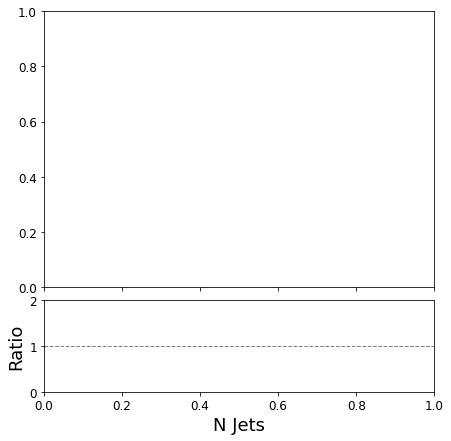

<Figure size 504x504 with 0 Axes>

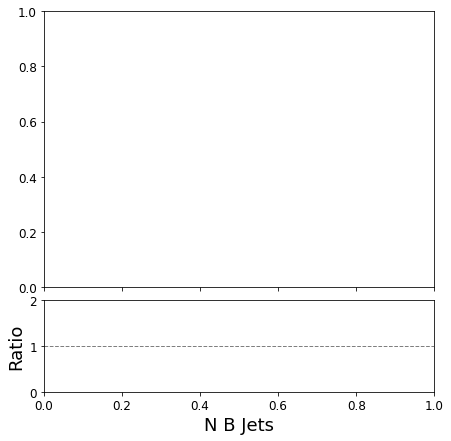

<Figure size 504x504 with 0 Axes>

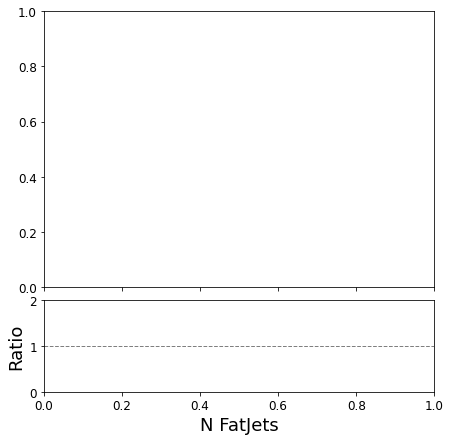

<Figure size 504x504 with 0 Axes>

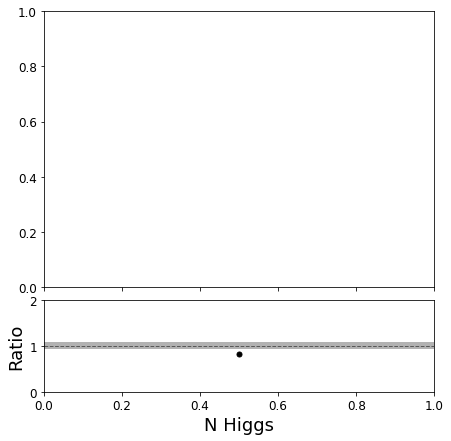

<Figure size 504x504 with 0 Axes>

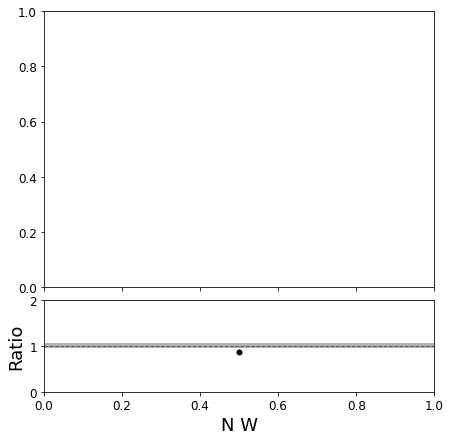

<Figure size 504x504 with 0 Axes>

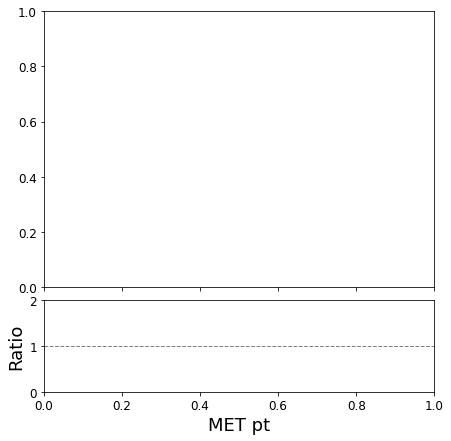

<Figure size 504x504 with 0 Axes>

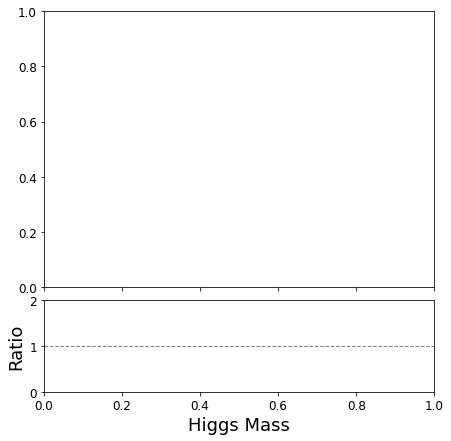

<Figure size 504x504 with 0 Axes>

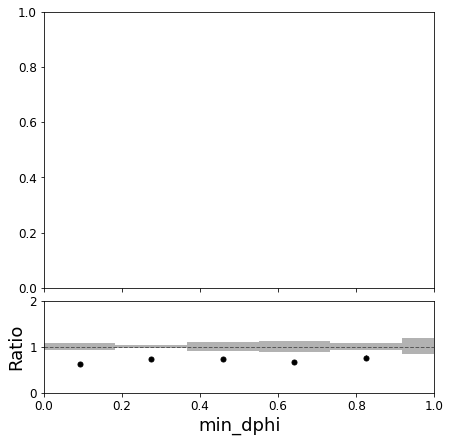

In [65]:
for name in histograms:
    print (name)
    histo_sig = output_sig[name]
    histo_back = output_back[name]
    histo_data = output_data[name]
    #rebinning
    if name == "number j":
        new_nj_bins = hist.Bin('multiplicity', r'N Jets', 20, 0, 20)
        histo_sig = histo_sig.rebin('multiplicity', new_nj_bins)
        histo_back = histo_back.rebin('multiplicity', new_nj_bins)
        histo_data = histo_data.rebin('multiplicity', new_nj_bins)
    if name == "number b":
        new_nb_bins = hist.Bin('multiplicity', r'N B Jets', 10, 0, 10)
        histo_sig = histo_sig.rebin('multiplicity', new_nb_bins)
        histo_back = histo_back.rebin('multiplicity', new_nb_bins)
        histo_data = histo_data.rebin('multiplicity', new_nb_bins)
    if name == "number fj":
        new_nfj_bins = hist.Bin('multiplicity', r'N FatJets', 10, 0, 10)
        histo_sig = histo_sig.rebin('multiplicity', new_nfj_bins)
        histo_back = histo_back.rebin('multiplicity', new_nfj_bins)
        histo_data = histo_data.rebin('multiplicity', new_nfj_bins)
    if name == "number h":
        new_nh_bins = hist.Bin('multiplicity', r'N Higgs', 10, 0, 10)
        histo_sig = histo_sig.rebin('multiplicity', new_nh_bins)
        histo_back = histo_back.rebin('multiplicity', new_nh_bins)
        histo_data = histo_data.rebin('multiplicity', new_nh_bins)
    if name == "number w":
        new_nw_bins = hist.Bin('multiplicity', r'N W', 10, 0, 10)
        histo_sig = histo_sig.rebin('multiplicity', new_nw_bins)
        histo_back = histo_back.rebin('multiplicity', new_nw_bins)
        histo_data = histo_data.rebin('multiplicity', new_nw_bins)
    if name == "met":
        new_met_bins = hist.Bin('pt', r'MET pt', 50, 200, 1000)
        histo_sig = histo_sig.rebin('pt', new_met_bins)
        histo_back = histo_back.rebin('pt', new_met_bins)
        histo_data = histo_data.rebin('pt', new_met_bins)
    if name == "h mass":
        new_hm_bins = hist.Bin('mass', r'Higgs Mass', 50, 0, 250)
        histo_sig = histo_sig.rebin('mass', new_hm_bins)
        histo_back = histo_back.rebin('mass', new_hm_bins)
        histo_data = histo_data.rebin('mass', new_hm_bins)
    if name == "min_dphi":
        new_min_bins = hist.Bin('eta', r'min_dphi', 60, -5.5, 5.5)
        histo_sig = histo_sig.rebin('eta', new_min_bins)
        histo_back = histo_back.rebin('eta', new_min_bins)
        histo_data = histo_data.rebin('eta', new_min_bins)
        
    savefig(histo_sig, histo_back, histo_data, outdir, name)
    savefigshape(histo_sig, histo_back, histo_data, outdir, name)